# Description

- Initialize with returns, predictions, target volatility, and oos start date
- Evaluate portfolios generated from the predictions

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import pandas as pd

import core.artificial_signal_generators as sig_gen
import core.config as cfg
import core.config_builders as cfgb
import core.model_evaluator as modeval
import core.model_plotter as modplot
import core.statistics as stats
import helpers.dbg as dbg
import helpers.env as env
import helpers.printing as prnt

In [2]:
dbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", env.get_system_signature()[0])

prnt.config_notebook()

# Packages
         python: 3.7.6
       gluonnlp: 0.9.1
        gluonts: 0.5.0
         joblib: 0.15.1
          mxnet: 1.6.0
          numpy: 1.18.4
         pandas: 1.0.3
        pyarrow: 0.17.1
          scipy: 1.4.1
        seaborn: 0.10.1
        sklearn: 0.23.1
    statsmodels: 0.11.1
# Last commits:
  *   c1f03c8f GP Saggese Merge pull request #742 from alphamatic/AmpTask726_Dogfood_run_test2.py_and_playback_on_render_md.py (   3 hours ago) Tue Sep 29 11:55:58 2020  (HEAD -> master, origin/master, origin/HEAD)
  |\  
  | *   7a1ba13a plyq     Merge remote-tracking branch 'origin' into AmpTask726_Dogfood_run_test2.py_and_playback_on_render_md.py (   4 hours ago) Tue Sep 29 11:41:38 2020           
  | |\  
  | |/  
  |/|   
  | * 6b0f5db9 plyq     AmpTask726: fixed playback documentation                          (   4 hours ago) Tue Sep 29 11:36:59 2020           


# Notebook config

In [3]:
eval_config = cfgb.get_config_from_nested_dict(
    {
        "target_volatility": 0.1,
        "oos_start": "2007-01-01",
        "bh_adj_threshold": 0.1,
        "resample_rule": "W",
        "mode": "ins"
    }
)

# Generate mock returns and predictions

- This is a placeholder
- In practice, the user should supply `rets` and `preds`

In [4]:
# Generate synthetic returns.
mn_process = sig_gen.MultivariateNormalProcess()
mn_process.set_cov_from_inv_wishart_draw(dim=32, seed=0)
realization = mn_process.generate_sample(
    {"start": "2000-01-01", "end": "2010-01-01", "freq": "B"}, seed=0
)
rets = realization.to_dict(orient="series")

In [5]:
# Generate fake predictions.
noise = sig_gen.MultivariateNormalProcess(pd.Series(data=[0]*32), pd.DataFrame(np.identity(32)))
noise_draw = noise.generate_sample(
    {"start": "2000-01-01", "end": "2010-01-01", "freq": "B"}, seed=0
)
pred_df = 0.01*realization + 0.1*noise_draw
# Adjust so that all models have positive SR.
pred_df = stats.compute_annualized_sharpe_ratio(pred_df.multiply(realization)).apply(np.sign).multiply(pred_df)

In [6]:
preds = pred_df.to_dict(orient="series")

# Initialize ModelEvaluator and ModelPlotter

In [7]:
evaluator = modeval.ModelEvaluator(
    returns=rets,
    predictions=preds,
    target_volatility=eval_config["target_volatility"],
    oos_start=eval_config["oos_start"],
)
plotter = modplot.ModelPlotter(evaluator)

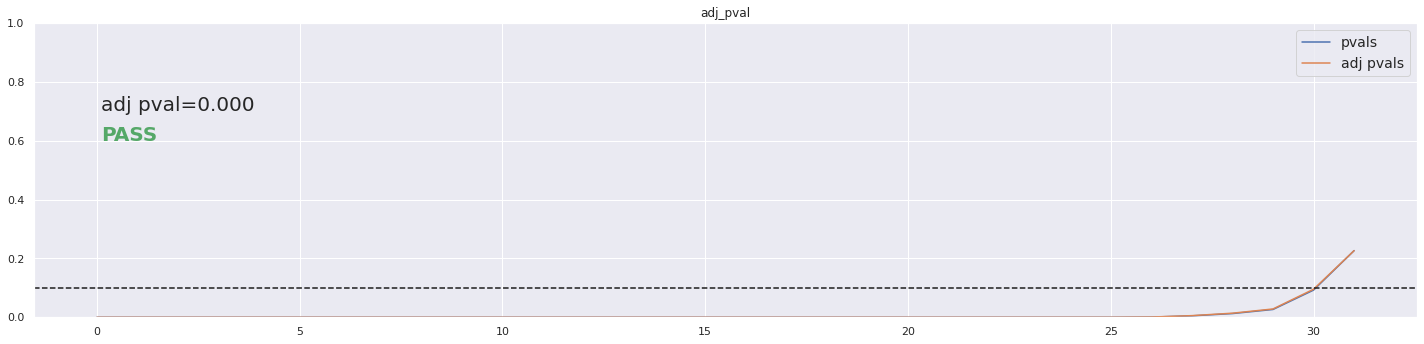

In [8]:
plotter.plot_multiple_tests_adjustment(threshold=eval_config["bh_adj_threshold"],
                                       mode=eval_config["mode"])

In [9]:
pnl_stats = evaluator.calculate_stats(mode=eval_config["mode"])
pnl_stats

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
sharpe_ratio,10.5858,6.40866,5.44653,7.127,0.636423,3.7445,2.19853,4.50217,4.48564,2.65197,3.0915,2.61523,3.5382,3.68917,6.27558,3.52115,3.4617,1.27792,6.87148,0.94338,1.06347,4.42337,5.07674,0.457259,1.59125,4.97684,3.69454,1.90851,1.90551,3.66421,6.0127,0.839097
sharpe_ratio_standard_error,0.416709,0.39268,0.38868,0.396057,0.378228,0.383127,0.379828,0.385355,0.385302,0.380621,0.381528,0.380551,0.38259,0.38298,0.392091,0.382547,0.382398,0.378672,0.394818,0.378403,0.378491,0.385105,0.387307,0.378157,0.378997,0.386951,0.382995,0.379398,0.379394,0.382915,0.39096,0.378336
tval,28.0065,16.9551,14.4097,18.8556,1.68376,9.90667,5.81656,11.9112,11.8675,7.0162,8.17906,6.91901,9.36089,9.7603,16.6031,9.31576,9.15848,3.38093,18.1796,2.49586,2.81359,11.7027,13.4313,1.20975,4.20991,13.167,9.77449,5.04926,5.04133,9.69427,15.9076,2.21996
pval,7.02321e-144,5.4024e-60,1.15366e-44,1.34155e-72,0.092399,1.42885e-22,7.07746e-09,1.47848e-31,2.40356e-31,3.20076e-12,5.29817e-16,6.2719e-12,2.24304e-20,5.68403e-22,9.18509e-58,3.36855e-20,1.37129e-19,0.000737632,5.21559e-68,0.0126528,0.00495171,1.47921e-30,2.72665e-39,0.226531,2.67898e-05,6.84113e-38,4.97591e-22,4.87747e-07,5.08125e-07,1.05342e-21,1.85306e-53,0.0265436
kratio,13.7259,10.5425,8.46439,7.66902,0.440259,6.16385,1.87807,8.11319,5.0736,2.93937,3.09754,4.81766,4.82065,2.86184,6.45748,4.33805,4.68245,1.36018,8.41147,1.6315,2.04593,4.98662,6.7173,0.7768,2.18152,3.81253,3.20698,2.06032,3.31552,4.79923,5.69652,0.907018
annualized_mean_return_(%),105.858,64.0866,54.4653,71.27,6.36423,37.445,21.9853,45.0217,44.8564,26.5197,30.915,26.1523,35.382,36.8917,62.7558,35.2115,34.617,12.7792,68.7148,9.4338,10.6347,44.2337,50.7674,4.57259,15.9125,49.7684,36.9454,19.0851,19.0551,36.6421,60.127,8.39097
annualized_volatility_(%),10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
max_drawdown_(%),-0.388467,-3.20168,-3.46109,-2.96255,-22.5159,-5.26212,-10.259,-5.78487,-3.7742,-9.04286,-6.58218,-8.4257,-6.64833,-6.05749,-4.40957,-5.69937,-8.07694,-15.3392,-2.70696,-13.1766,-11.6073,-5.79475,-4.20986,-13.3726,-12.0311,-4.71245,-4.86216,-16.8058,-6.81266,-5.56687,-3.04112,-13.5331
start_time,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00,2000-01-03 00:00:00
end_time,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00,2007-01-01 00:00:00


The corr_df.shape[0]='32' > 20


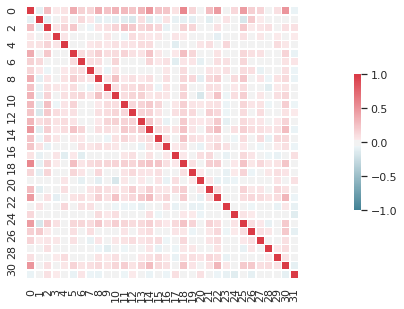

In [10]:
plotter.plot_correlation_matrix(series="pnls",
                                resample_rule=eval_config["resample_rule"],
                                mode=eval_config["mode"])

The corr_df.shape[0]='32' > 20


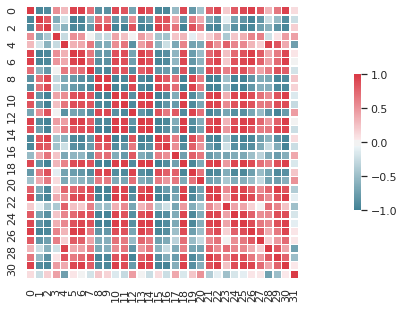

In [11]:
plotter.plot_correlation_matrix(series="returns",
                                resample_rule=eval_config["resample_rule"],
                                mode=eval_config["mode"])

In [12]:
col_mask = pnl_stats.loc["adj_pval"] < eval_config["bh_adj_threshold"]
selected = pnl_stats.loc[:, col_mask].columns.to_list()

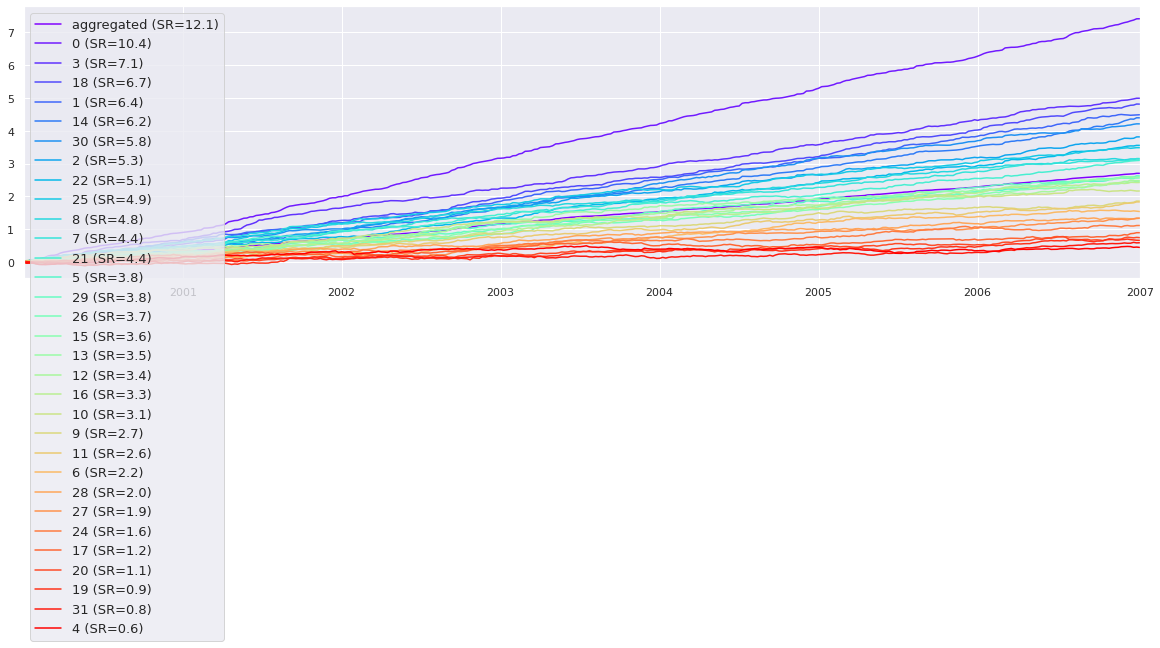

In [13]:
plotter.plot_multiple_pnls(keys=selected,
                           resample_rule=eval_config["resample_rule"],
                           mode=eval_config["mode"])

In [14]:
evaluator.aggregate_models(keys=selected,
                           mode=eval_config["mode"],
                           target_volatility=eval_config["target_volatility"])[2].to_frame()

,stats
sharpe_ratio,12.4134
sharpe_ratio_standard_error,0.430305
tval,32.8415
pval,2.90502e-186
kratio,14.1915
annualized_mean_return_(%),124.134
annualized_volatility_(%),10
max_drawdown_(%),-1.21641
start_time,2000-01-03 00:00:00
end_time,2007-01-01 00:00:00


Upsampling from input freq='B' to freq='D' is blocked


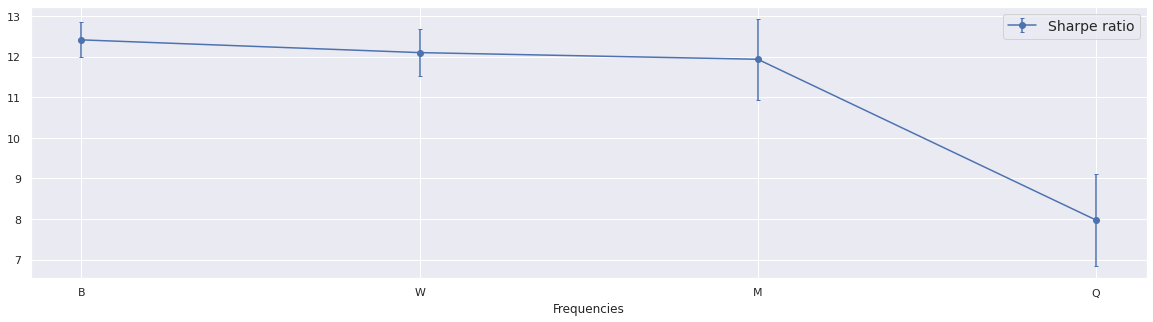

In [15]:
plotter.plot_sharpe_ratio_panel(keys=selected,
                                mode=eval_config["mode"])

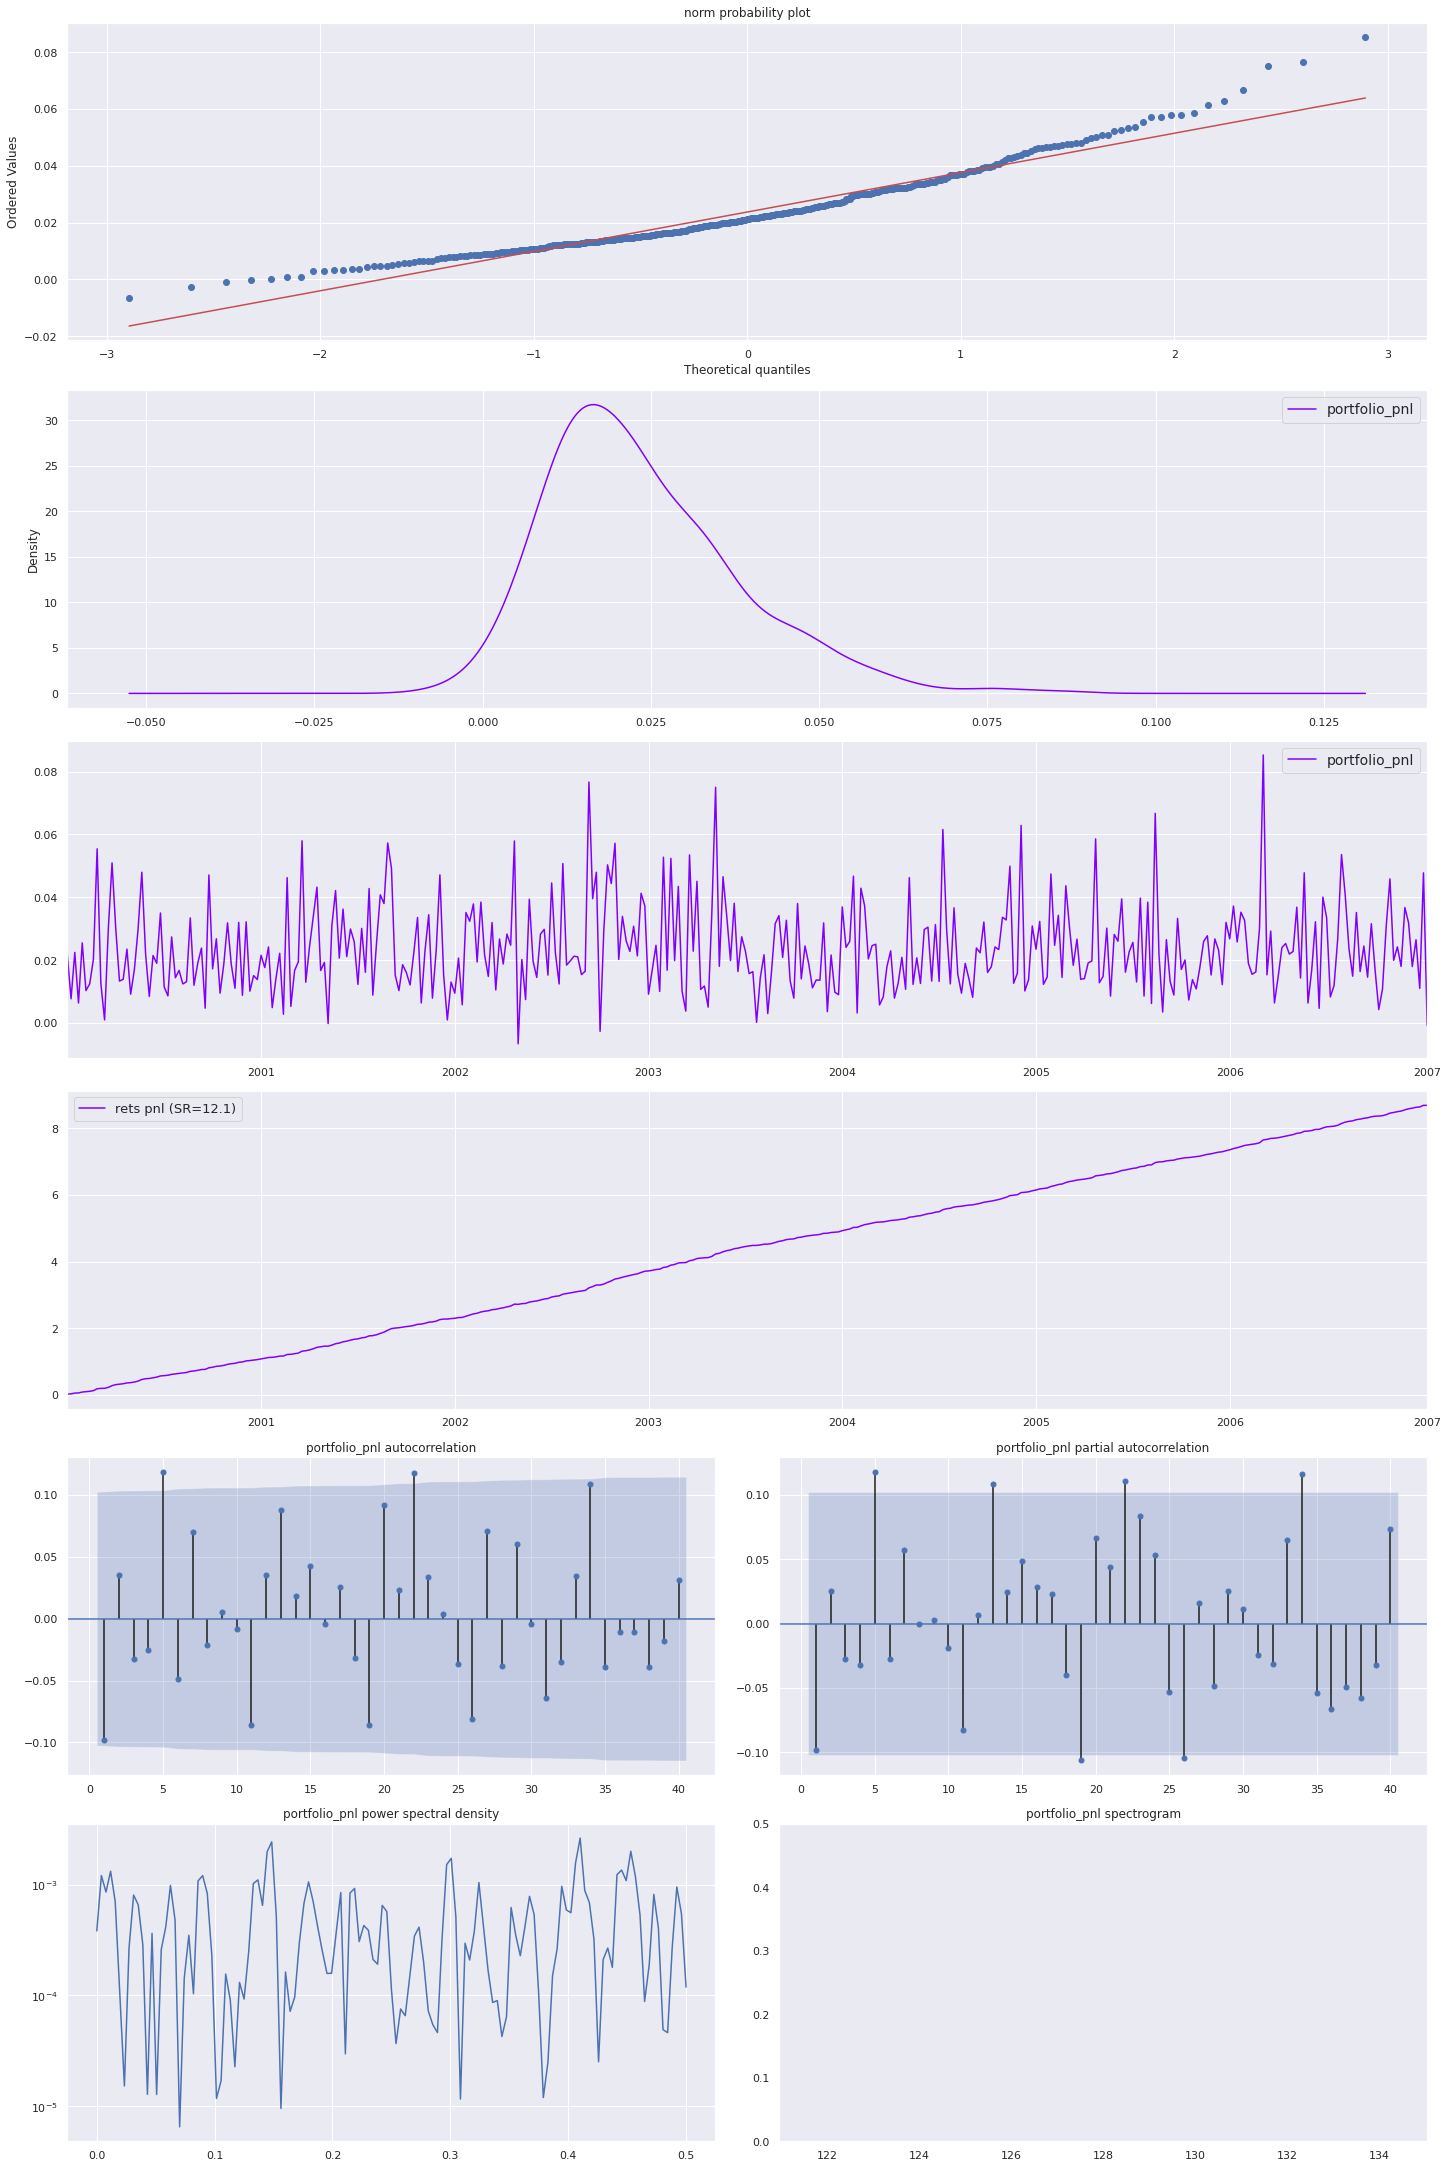

In [16]:
plotter.plot_rets_signal_analysis(keys=selected,
                                  resample_rule=eval_config["resample_rule"],
                                  mode=eval_config["mode"],
                                  target_volatility=eval_config["target_volatility"])

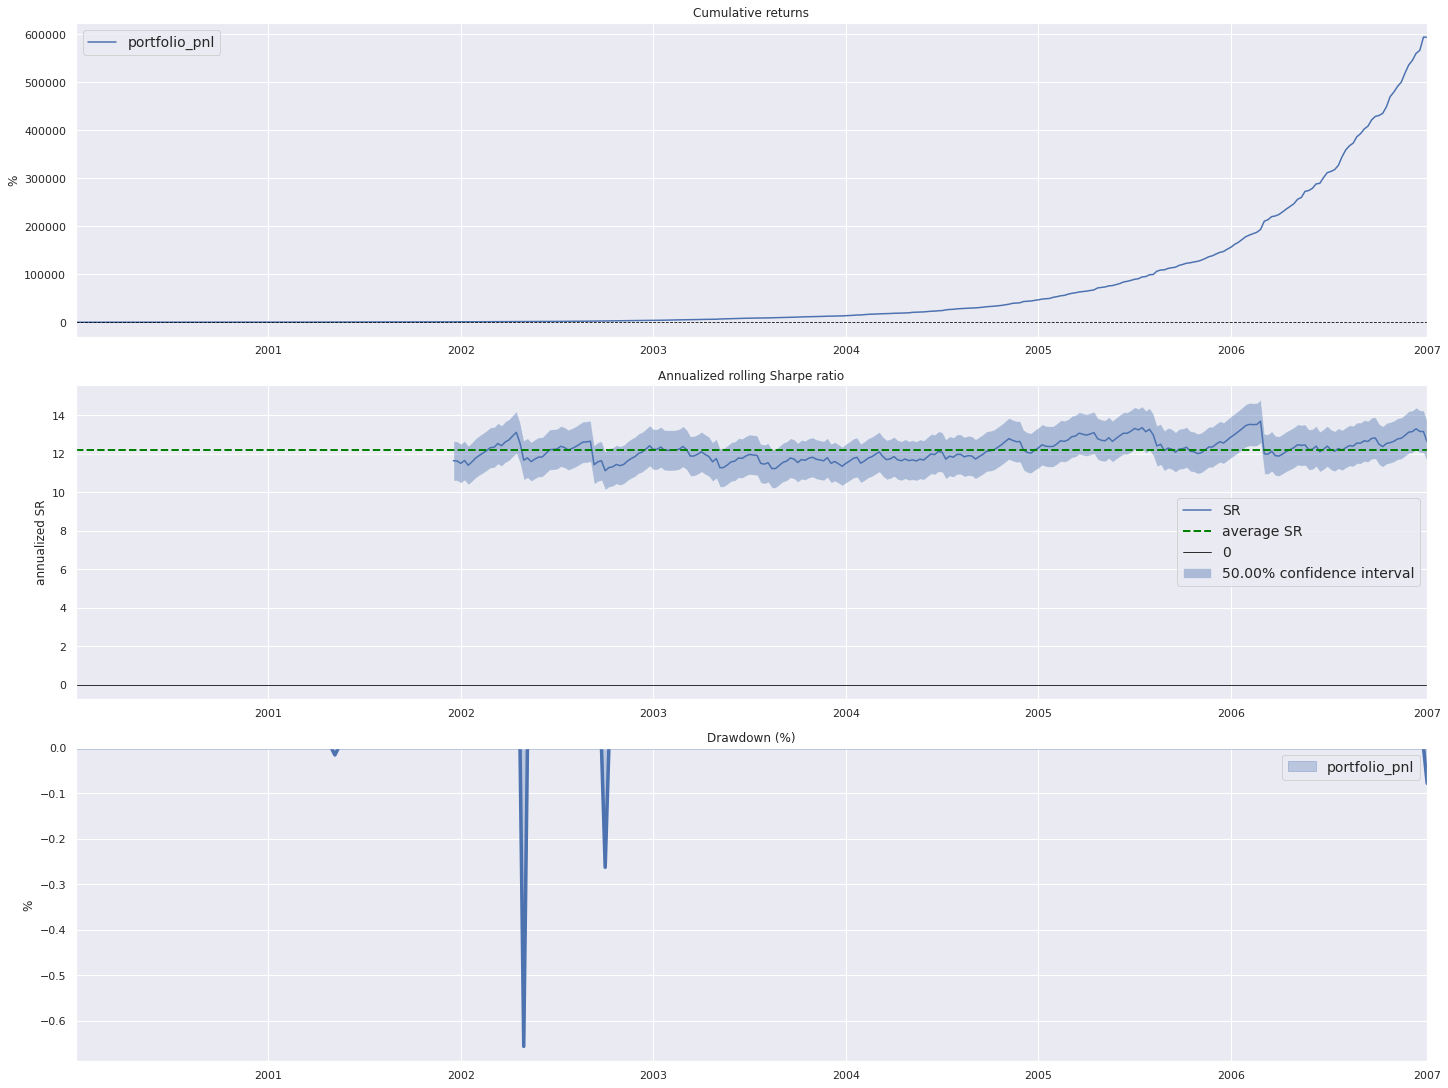

In [17]:
plotter.plot_performance(keys=selected,
                         resample_rule=eval_config["resample_rule"],
                         mode=eval_config["mode"],
                         target_volatility=eval_config["target_volatility"])

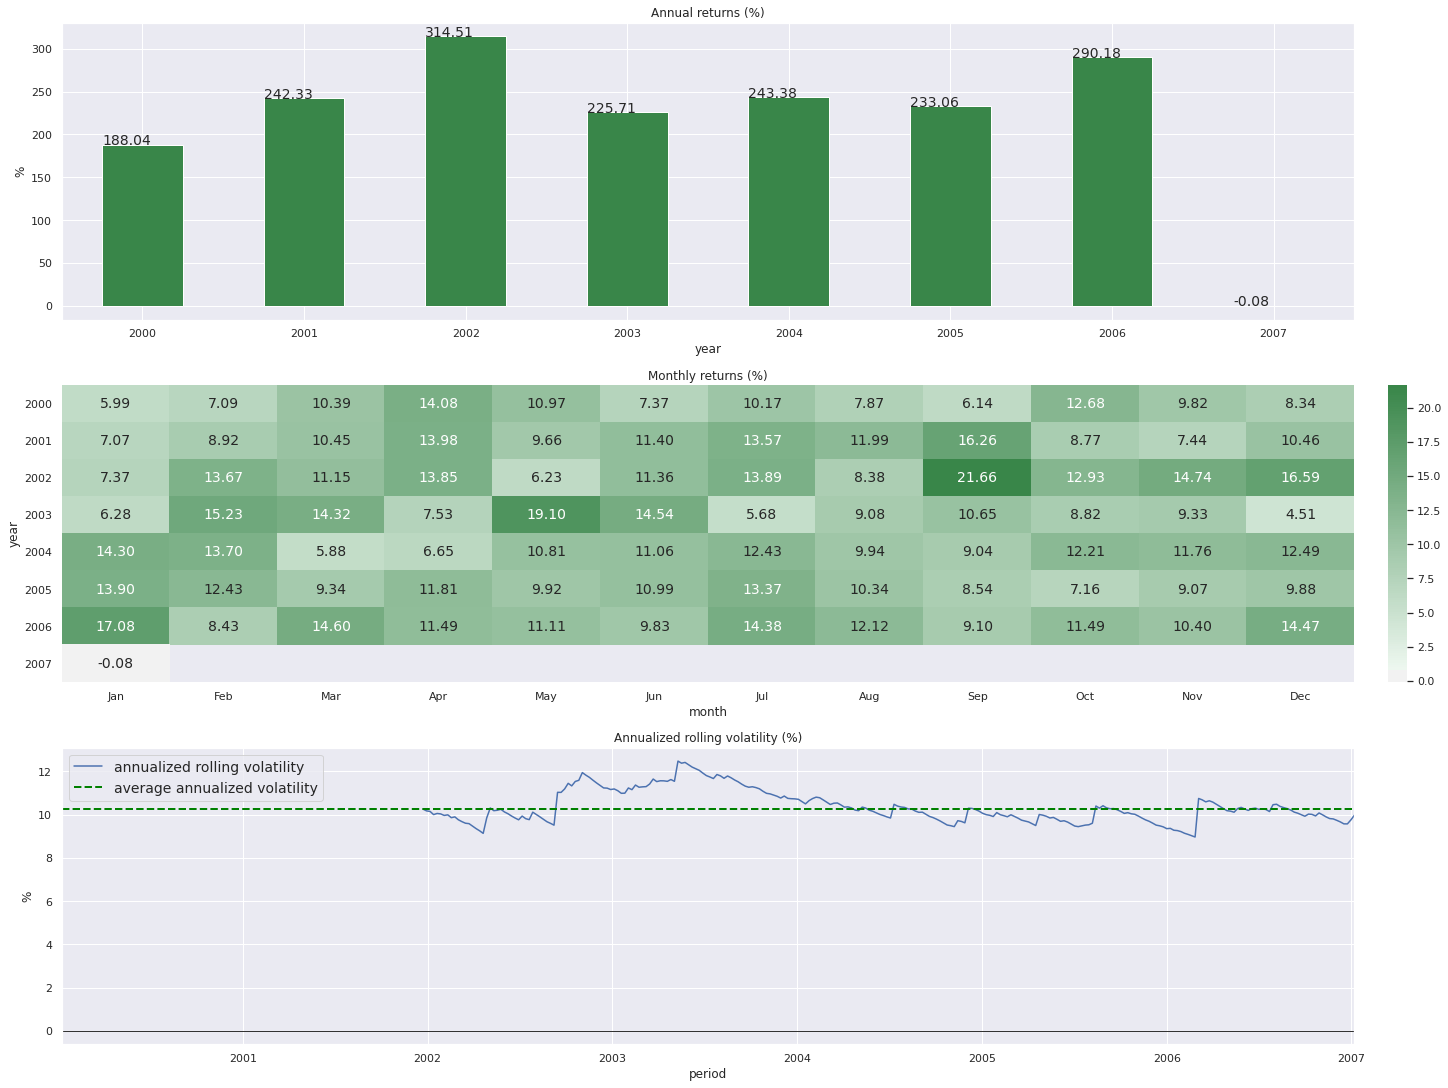

In [18]:
plotter.plot_rets_and_vol(selected,
                          resample_rule=eval_config["resample_rule"],
                          mode=eval_config["mode"],
                          target_volatility=eval_config["target_volatility"])

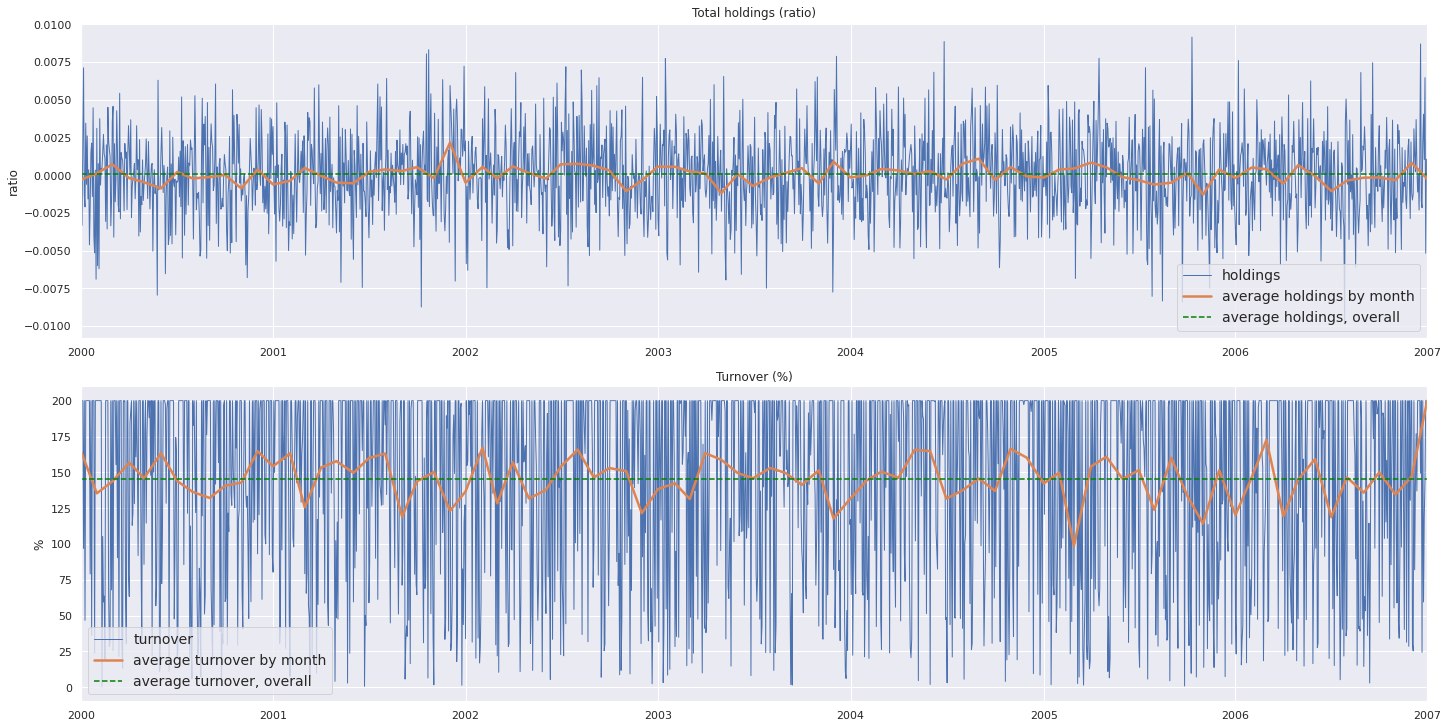

In [19]:
plotter.plot_positions(keys=selected,
                       mode=eval_config["mode"],
                       target_volatility=eval_config["target_volatility"])

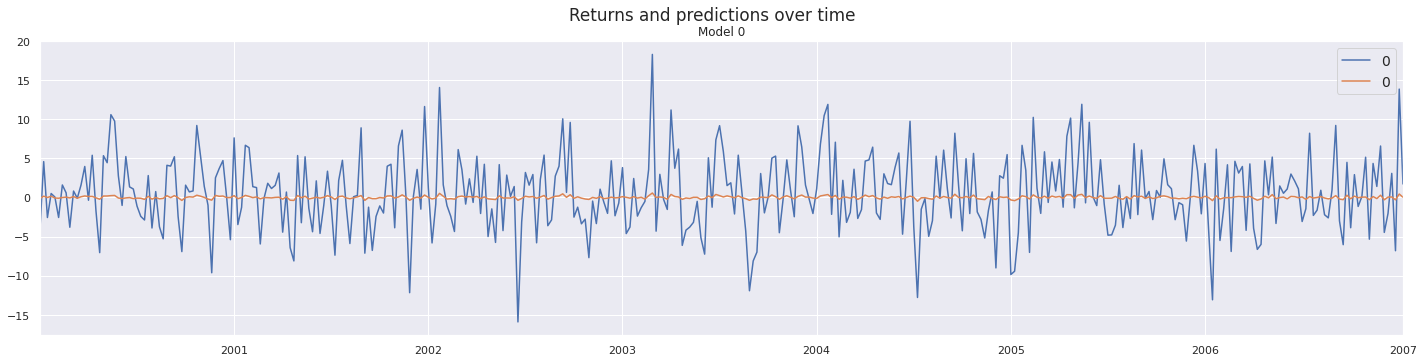

In [20]:
plotter.plot_returns_and_predictions(keys=selected[:1],
                                     resample_rule=eval_config["resample_rule"],
                                     mode=eval_config["mode"])